In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.backends.backend_pdf as backend_pdf
import matplotlib.pyplot as plt
import re
from numpy import genfromtxt
from ete3 import Tree
import seaborn as sns
import arviz as az

In [2]:
os.getcwd()

'/Users/lkn315/Library/CloudStorage/OneDrive-UniversityofCopenhagen/SPMS/experiments/original/3-simulation-study'

In [3]:
nnodes = 9
tree = Tree('../../data/chazot_subtree.nw') 


In [4]:
leafidx = []
inneridx = []
i = 0
for node in tree.traverse('levelorder'):
    if node.is_leaf():
        print(node.name)
        leafidx.append(i)
    else:
        inneridx.append(i)
    i+=1
print(leafidx)
print(inneridx)


niepelti
theseus
hercules
amphitryon
telemachus
[3, 4, 5, 7, 8]
[0, 1, 2, 6]


In [7]:
# settings 
simseed = 78241558624040307
MCMC_iter = 6000
burnin = 2000
nthin = 1 # see from script/running conditions, not used for plotting
folder_runs = f'../results/_sim-30-leaves/runs_v2/{simseed}/' 
folder_simdata = f'../results/_sim-30-leaves/simdata/{simseed}/' 
nnodes = 9
#levelorder_tree = Tree('chazot_subtree_levelorder.nw') 
nxd = 40
pars_name = ['kalpha', 'gtheta']
rep_path = len(pars_name)+1
chains = os.listdir(folder_runs) # use all chains in data seed folder 
chains = [c for c in chains if c[0] not in ['_', '.']] # remove files starting with underscore
print(chains)

# read true parameters
true_pars = [np.genfromtxt(folder_simdata +p+"_sim.csv", delimiter = ",") for p in pars_name]
true_pars

# PLOT TRACE AND DENSITY FOR PARAMETERS
# wait with array in case of irregular dimensions 
temp_name = ['' for i in range(len(chains))]
raw_pars = [[np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+par+"s.csv", delimiter = ",") for i in range(len(chains))] for par in pars_name]
raw_acceptpars = [[np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"acceptkalpha.csv", delimiter = ",") for i in range(len(chains))] for par in pars_name]

pars = [np.array([raw_pars[j][i][burnin:MCMC_iter] for i in range(len(raw_pars[0]))]) for j in range(len(raw_pars))]
[p.shape for p in pars]
acceptpars = [np.array([raw_acceptpars[j][i][burnin:MCMC_iter] for i in range(len(raw_acceptpars[0]))]) for j in range(len(raw_acceptpars))]
[ap.shape for ap in acceptpars]


['magic-leaf-531', 'young-sky-529', 'expert-shadow-529']


[(3, 4000), (3, 4000)]

In [8]:
# get rhat for parameters 
parsdict = dict(zip(pars_name, pars)) 
MCMC_result = parsdict #parsdict|innernodedict
parsres = az.convert_to_dataset(MCMC_result)
rhat = az.rhat(parsres)
mcse = az.mcse(parsres)
ess = az.ess(parsres)
az.summary(parsres)

# save rhat for plotting
rhats_par = np.array([rhat['kalpha'], rhat['gtheta']])

In [9]:
pars_name = ['kalpha', 'gtheta']
true_vals = {}

for par in pars_name:
    file_path = os.path.join(folder_simdata, f"{par}_sim.csv")
    true_vals[par] = np.genfromtxt(file_path, delimiter=",")
    
print(true_vals)
true_vals = list(true_vals.values()) #[true_pars]
true_vals

{'kalpha': array(0.01), 'gtheta': array(0.6)}


[array(0.01), array(0.6)]

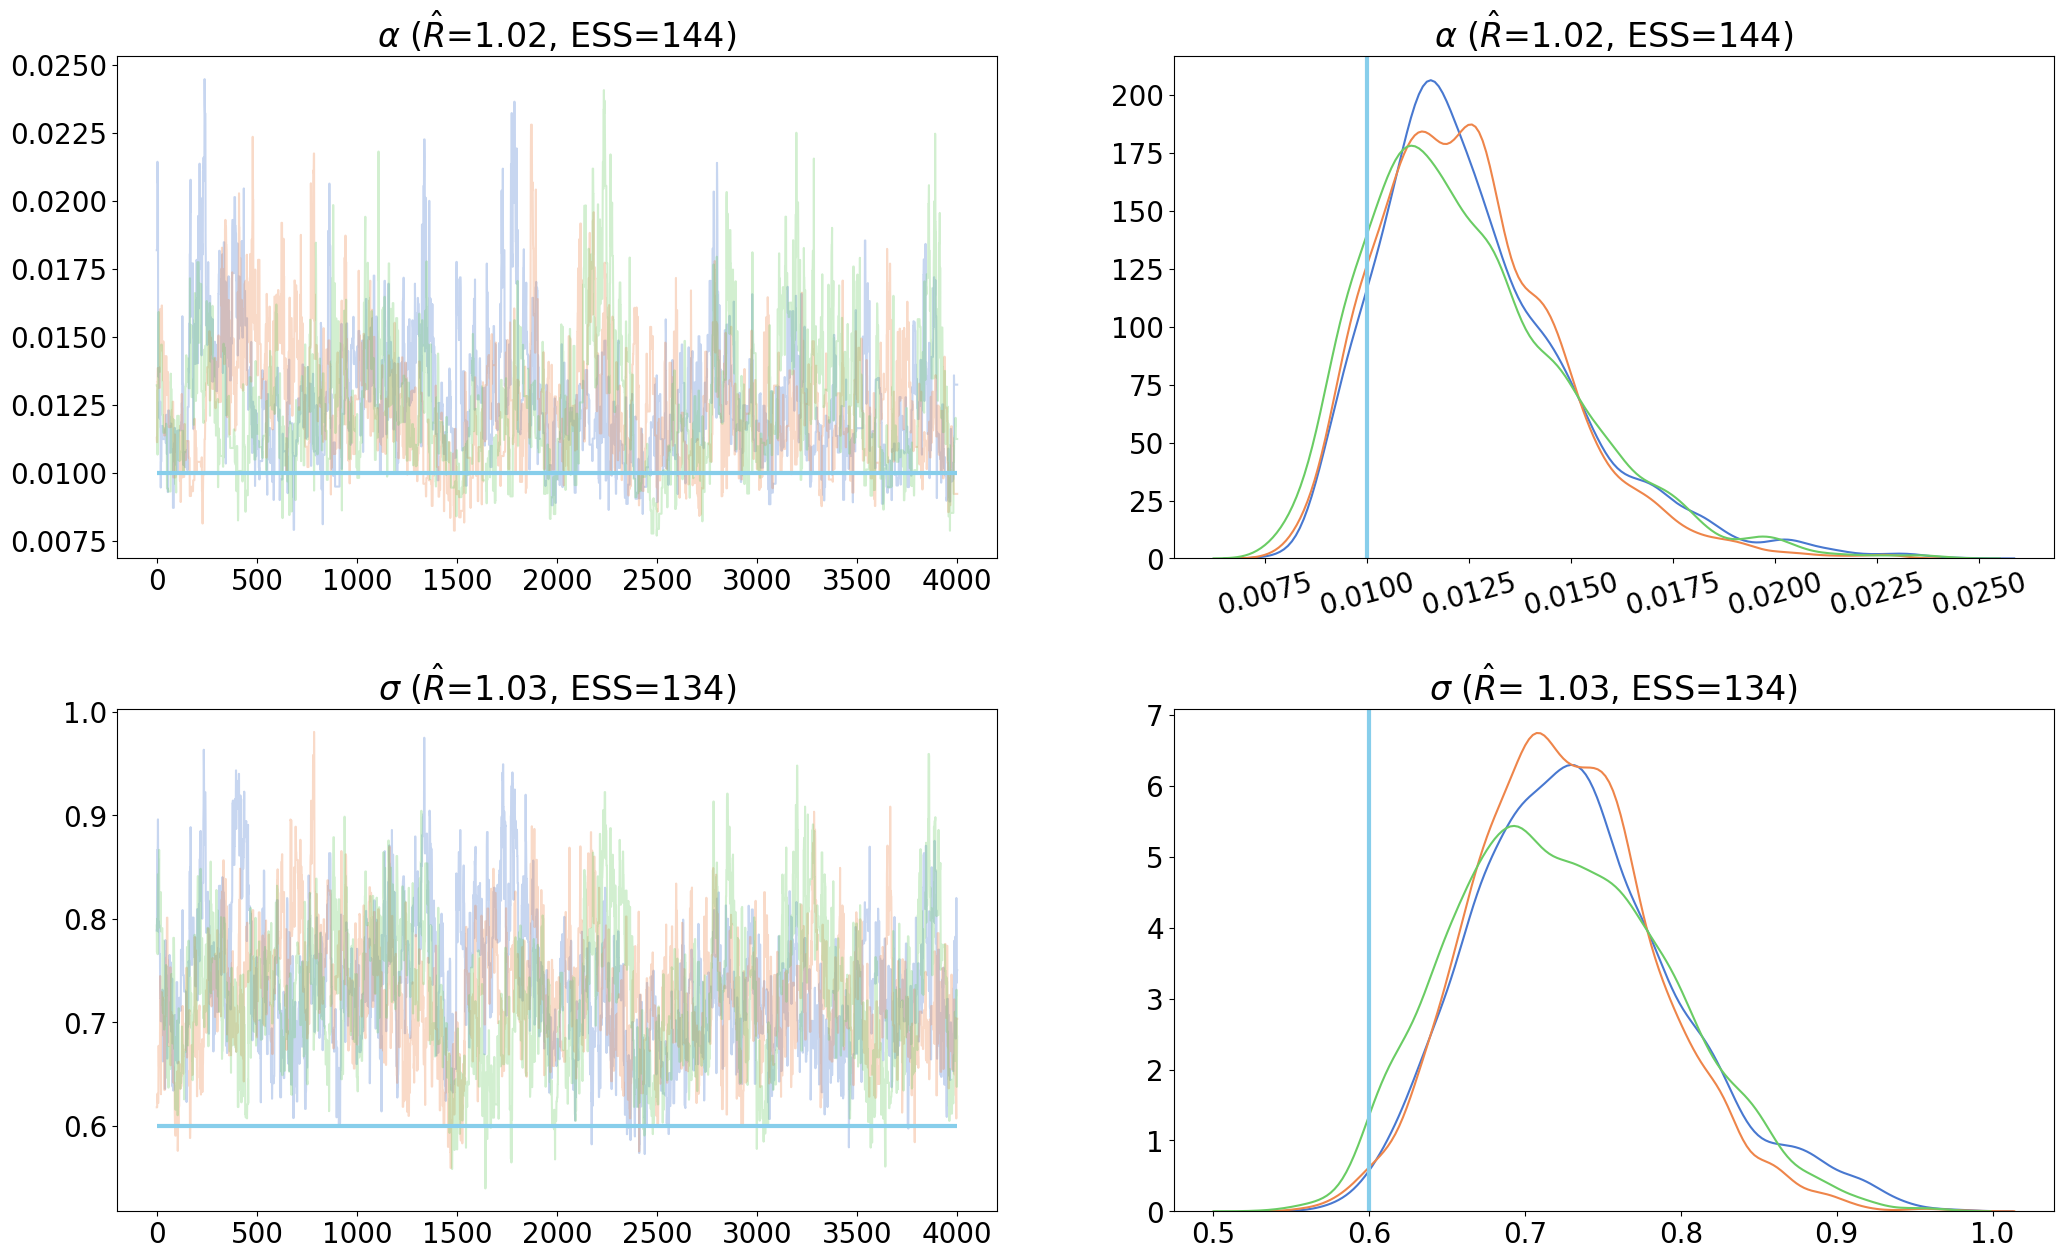

In [ ]:
#true_vals = true_pars.values() #[true_pars]
import matplotlib.ticker as mticker

plt.rcParams.update({'font.size': 20})
keys = pars_name
colors = sns.color_palette('muted', len(chains))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))
p = 0
cp = 0
name = ['$\alpha$']
for i, ax in zip(range(len(axes.flat)), axes.flat): 
        if i%2 == 0: 
            for j in range(pars[p].shape[0]): #loop over chains 
                ax.plot(pars[p][j,:], color=colors[j], alpha=0.3)
            ax.hlines(y=true_vals[p], xmin=0, xmax=pars[p].shape[1], color='skyblue', linewidth=3)
            #ax.set_title(f'{keys[p]}, rhat: {round(float(np.array(rhat[keys[p]])),2)} \n (ess: {round(float(np.array(ess[keys[p]])),2)}) ')
            p+=1
        if i%2==1:
            for j in range(pars[cp].shape[0]):
                sns.kdeplot(pars[cp][j,:], ax=ax, color=colors[j])
                #sns.rugplot(pars[cp][j,:], ax=ax)
            ax.axvline(x = true_vals[cp], ymin = 0, ymax = 1, color='skyblue', linewidth=3) 
            ax.set_ylabel("")  # Remove y-axis label
            ax.set(ylabel=None)  # Also remove label if set by seaborn
            #ax.set_title(f'{keys[cp]}, rhat: {round(float(np.array(rhat[keys[cp]])),2)} \n (ess: {round(float(np.array(ess[keys[cp]])),2)}) ')#
            cp+=1
        #if i%3==2:
        #    ax.scatter(list(range(len(all_rhats_pars[:,cp]))), all_rhats_pars[:,cp])
        #    ax.hlines(y=1.1, xmin=0, xmax=len(all_rhats_pars[:,cp]), color='red', linestyle='dashed', linewidth=2)
        #    ax.hlines(y=1.0, xmin=0, xmax=len(all_rhats_pars[:,cp]), color='green', linestyle='dashed', linewidth=2)
        #    cp+=1

#fig.suptitle(f"Iter: {MCMC_iter}, Burnin: {burnin} \n", fontsize=15)
#fig.tight_layout()

axes[0,0].set_title(r'$\alpha$ ($\hat{R}$='+ f'{round(float(np.array(rhat[keys[0]])),2)}, ESS={round(float(np.array(ess[keys[0]])))})')
axes[0,1].set_title(r'$\alpha$ ($\hat{R}$='+ f'{round(float(np.array(rhat[keys[0]])),2)}, ESS={round(float(np.array(ess[keys[0]])))})')
axes[0,1].tick_params(axis='x', labelrotation=15)
#axes[0,1].xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
#axes[0,1].ticklabel_format(style='sci', axis='x', scilimits=(-3,-3))
#axes[0,1].xaxis.get_offset_text().set_fontsize(16)  # Make the offset text larger if needed

axes[1,0].set_title(r'$\sigma$ ($\hat{R}$='+ f'{round(float(np.array(rhat[keys[1]])),2)}, ESS={round(float(np.array(ess[keys[1]])))})')
axes[1,1].set_title(r'$\sigma$ ($\hat{R}$= '+ f'{round(float(np.array(rhat[keys[1]])),2)}, ESS={round(float(np.array(ess[keys[1]])))})')
#axes[1,2].set_title(r'$\sigma$')

plt.subplots_adjust(hspace=0.3)  # Increase vertical space (default is 0.2)
plt.savefig(f'convergence_plot_sim-30-leaves_{simseed}.pdf')